<a href="https://colab.research.google.com/github/MarianickB/BMP/blob/master/tSNE_Marianick_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

In [42]:
import numpy as np
import pylab
import torch
import torchvision
import torchvision.datasets as datasets
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import scipy.io as sio
from os.path import dirname, join as pjoin


# MNIST
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

#COIL20
#https://discuss.pytorch.org/t/load-coil20-dataset/2508/9



#Load MNIST

In [3]:
X_mnist = mnist_trainset.data.numpy()
X_labels = mnist_trainset.targets.data.numpy()

X_test = mnist_testset.data.numpy()
X_test_labels = mnist_testset.targets.data.numpy()

X = X_mnist.reshape(X_mnist.shape[0], 784)

#Load Olivetti

In [38]:
#OLIVETTI
d = fetch_olivetti_faces(data_home=None, shuffle=False, random_state=0, download_if_missing=True)

train_num = 5
train_repeat = 1

test_size = (10. - train_num) / 10
X = d.images
y = d.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=3, stratify=y)
if train_repeat > 1:
    X_train = X_train.repeat(train_repeat, axis=0)
    y_train = y_train.repeat(train_repeat)

X_olivetti = X_train
X_labels = y_train

X_test_labels = y_test

X = X_olivetti
#X=X_olivetti.reshape(X_olivetti.shape[0], 784)



#Load COIL20

In [60]:
mat_fname = pjoin('', 'COIL20.mat')
mat_contents = sio.loadmat(mat_fname)

data = list(mat_contents.items())
an_array = np.array(data)

X_train = an_array[3][1]
X_labels = an_array[4][1]

X_olivetti = X_train
X_labels = y_train

X_test_labels = y_test

X = X_olivetti


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [39]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1) 
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X)) # find eigenvalues and eigenvectors
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, max_iter=1000):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real # reduce dimensioality to initial_dims dimensions
    (n, d) = X.shape
    # max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

In [61]:
print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
print("Randomly select 6k instances from the 60k  MNIST digit examples and running...")
np.random.seed(511)
indx = np.random.randint(X.shape[0], size=2500)
# X_tr = X[indx,:].astype('float32')
X_tr = X[indx,:]
X_tr[X_tr>0]=1 # binarize the image
X_tr = 1-X_tr # reduce sparsity
Y = tsne(X_tr, no_dims=2, initial_dims=30, perplexity=40.0, max_iter=20)

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Randomly select 6k instances from the 60k  MNIST digit examples and running...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.145128
Iteration 10: error is 21.401451
Iteration 20: error is 17.858696


# TSNE - MNIST - DEFAULT VALUES (perplexity 40)



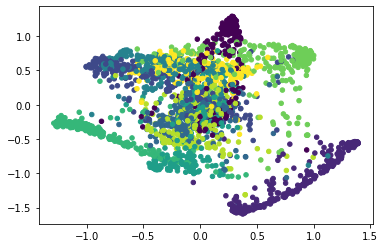

In [9]:
pylab.scatter(Y[:, 0], Y[:, 1], 20, X_labels[indx])
pylab.show()

#TSNE - MNIST - PERPLEXITY *5*

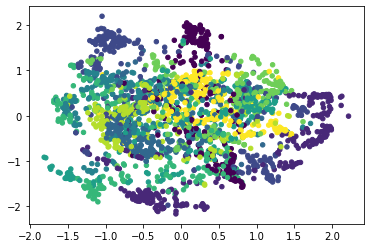

In [24]:
pylab.scatter(Y[:, 0], Y[:, 1], 20, X_labels[indx])
pylab.show()

#TSNE - MNIST - PERPLEXITY *20*

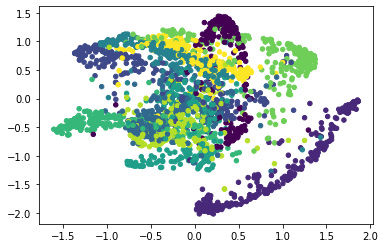

In [27]:
pylab.scatter(Y[:, 0], Y[:, 1], 20, X_labels[indx])
pylab.show()

#TSNE - MNIST - PERPLEXITY *50*

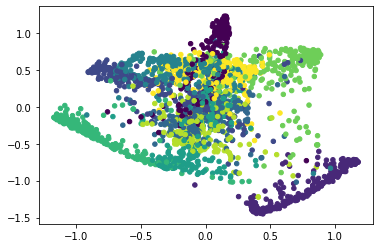

In [20]:
pylab.scatter(Y[:, 0], Y[:, 1], 20, X_labels[indx])
pylab.show()

#TSNE - MNIST - PERPLEXITY *100*

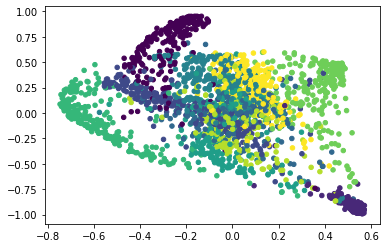

In [22]:
pylab.scatter(Y[:, 0], Y[:, 1], 20, X_labels[indx])
pylab.show()

#TSNE - COIL - DEFAULT 

In [64]:
pylab.scatter(Y[:, 0], Y[:, 1], 20, X_labels[indx])
pylab.show()

IndexError: ignored